## Setup

In [1]:
# change into the src directory
import git
import os

repo = git.Repo('.', search_parent_directories=True)
os.chdir(repo.working_tree_dir)

In [2]:
from tapas_gmm.policy.models.tpgmm import ModelType, TPGMM, ReconstructionStrategy, FittingStage, InitStrategy, _xdx_to_tangent, TPGMMConfig, AutoTPGMMConfig, AutoTPGMM, FrameSelectionConfig, DemoSegmentationConfig, CascadeConfig
# import lovely_tensors as lt
# lt.monkey_patch()
from lovely_numpy import lo
import matplotlib.pyplot as plt

import pathlib

# from pbdlib.utils.jupyter_utils import *
import numpy as np

from conf._machine import data_naming_config as machine_data_naming_config
from tapas_gmm.dataset.demos import Demos, PartialFrameViewDemos
import tapas_gmm.policy.models.tpgmm
from tapas_gmm.utils.misc import load_scene_data, DataNamingConfig
from tapas_gmm.utils.logging import setup_logger  # noqa: F401
from tapas_gmm.utils.franka import reconstruct_actions
from tapas_gmm.viz.gmm import plot_log_map_quaternions, plot_hmm_transition_matrix

%matplotlib inline

%load_ext autoreload
%autoreload 2

data_root = pathlib.Path(machine_data_naming_config.data_root).resolve()
data_root = data_root.parent / data_root.stem

np.set_printoptions(precision=2)

plt.style.use('default')

from IPython.display import HTML
from matplotlib import rc
rc('animation', html='jshtml')


2024-08-16 16:09:54.117 | INFO     |  Running on cuda:0


In [3]:
task = 'Pour'
path = data_root / task / 'demos'

data_config = DataNamingConfig(
    feedback_type=None,
    task=None,
    data_root=None,
    path=path,
)

scene_data = load_scene_data(data_config)


2024-08-16 16:09:55.328 | INFO     |  Loading dataset(s): 
2024-08-16 16:09:55.329 | INFO     |    Initializing datasete using /home/hartzj/MT-GMM/data/Pour/demos/metadata.json
2024-08-16 16:09:55.330 | INFO     |    Extracted gt object labels []
2024-08-16 16:09:55.330 | INFO     |    Extracted tsdf object labels []
2024-08-16 16:09:55.330 | INFO     |    Done! Data contains 4 trajectories.


In [4]:
kp_config = {
    'encoder_name': 'demos_vit_keypoints_encoder',
    'encoding_name': 'exp',
}


In [5]:
observations = scene_data.get_demos(**kp_config)

reconstruct_actions(observations)

n_obs = len(observations)


In [6]:
demo_meta_data = {
    'path': path
}

data_kwargs = dict(
    meta_data=demo_meta_data,
    add_init_ee_pose_as_frame=True,
    add_world_frame=False,
    frames_from_keypoints=True,
    enforce_z_down=False,
    modulo_object_z_rotation=False,
    make_quats_continuous=True,
    # kp_indeces=list(range(4)),
)

demos = Demos(observations, **data_kwargs)

2024-08-16 16:09:58.600 | INFO     |  Subsampling to length 422 using strategy mean-length.


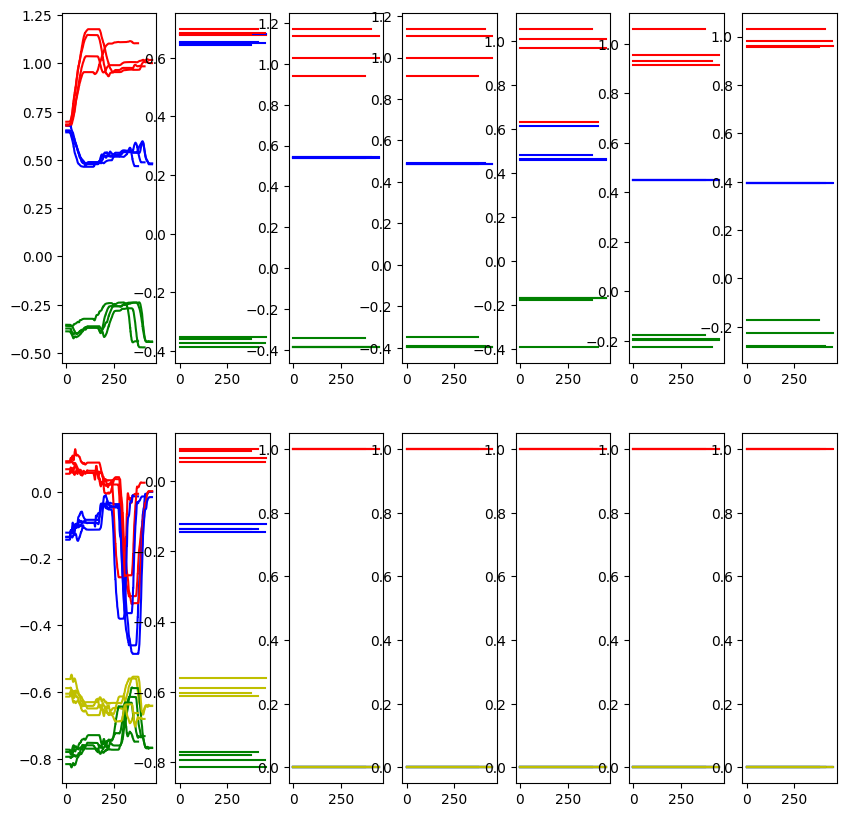

In [7]:
demos.debug_trajs()

In [8]:
tpgmm_config = TPGMMConfig(
    n_components=40,
    model_type=ModelType.HMM,
    use_riemann=True,
    add_time_component=True,
    add_action_component=False,
    position_only=False,

    action_as_orientation=False,
    action_with_magnitude=False,

    add_gripper_action=True,

    reg_init_diag=5e-5,
    reg_diag_gripper=2e-5,
    reg_em_finish_diag_gripper=2e-5,

    reg_shrink=1e-3,
    reg_diag=5e-5,

    reg_em_finish_shrink=1e-3,
    reg_em_finish_diag=5e-5,

    fix_first_component=False,
    fix_last_component=False,

    trans_cov_mask_t_pos_corr=False,

    em_steps=1,
)

frame_selection_config = FrameSelectionConfig(
    init_strategy=InitStrategy.TIME_BASED,
    fitting_actions=(FittingStage.INIT,),
    rel_score_threshold=0.45,
)

demo_segmentation_config = DemoSegmentationConfig(
    gripper_based=False,
    distance_based=False,
    velocity_based=True,

    repeat_final_step=0,

    use_gripper_states=False,

    min_end_distance=35,
    min_len=4,

    velocity_threshold=0.002,
    max_idx_distance=1,

    components_prop_to_len=True
)

cascade_config = CascadeConfig(
    min_prob=0.05,
    kl_keep_rotation_dim=False
)

auto_tpgmm_config = AutoTPGMMConfig(
    tpgmm=tpgmm_config,
    frame_selection=frame_selection_config,
    demos_segmentation=demo_segmentation_config,
    cascade=cascade_config,
)


In [9]:
atpgmm = AutoTPGMM(auto_tpgmm_config)


2024-08-16 16:10:00.315 | INFO     |  Fitting AutoTPGMM
2024-08-16 16:10:00.316 | INFO     |  Performing fitting actions: [INIT]
2024-08-16 16:10:00.317 | INFO     |  Segmenting trajectories


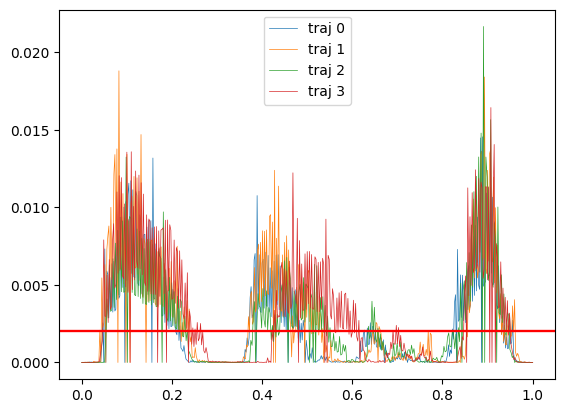

2024-08-16 16:10:00.544 | WARNING  |  Got different number of segmentation points for different trajectories.
Assuming it's because of settlement time.
Popping (tensor(365, dtype=torch.int32),) from traj 1 of len 450
2024-08-16 16:10:00.547 | WARNING  |  Got different number of segmentation points for different trajectories.
Assuming it's because of settlement time.
Popping (tensor(311, dtype=torch.int32),) from traj 2 of len 377
2024-08-16 16:10:00.548 | INFO     |  Creating segement of demos.
2024-08-16 16:10:00.550 | INFO     |  Subsampling to length 131 using strategy mean-length.
2024-08-16 16:10:00.550 | INFO     |  Creating segement of demos.
2024-08-16 16:10:00.553 | INFO     |  Subsampling to length 120 using strategy mean-length.
2024-08-16 16:10:00.553 | INFO     |  Creating segement of demos.
2024-08-16 16:10:00.564 | INFO     |  Subsampling to length 60 using strategy mean-length.
2024-08-16 16:10:00.565 | INFO     |  Creating segement of demos.
2024-08-16 16:10:00.567 | I

Time-based init:   0%|          | 0/12 [00:00<?, ?it/s]

2024-08-16 16:10:01.173 | INFO     |    Fitting candidate frame 2/6
2024-08-16 16:10:01.173 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/12 [00:00<?, ?it/s]

2024-08-16 16:10:01.796 | INFO     |    Fitting candidate frame 3/6
2024-08-16 16:10:01.796 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/12 [00:00<?, ?it/s]

2024-08-16 16:10:02.240 | INFO     |    Fitting candidate frame 4/6
2024-08-16 16:10:02.240 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/12 [00:00<?, ?it/s]

2024-08-16 16:10:02.773 | INFO     |    Fitting candidate frame 5/6
2024-08-16 16:10:02.773 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/12 [00:00<?, ?it/s]

2024-08-16 16:10:03.233 | INFO     |    Fitting candidate frame 6/6
2024-08-16 16:10:03.233 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/12 [00:00<?, ?it/s]

2024-08-16 16:10:03.737 | INFO     |  ee_init    score (rel):     -1 (1.000)
2024-08-16 16:10:03.738 | INFO     |  kp 0       score (rel):     -0 (0.482)
2024-08-16 16:10:03.738 | INFO     |  kp 1       score (rel):     -1 (0.536)
2024-08-16 16:10:03.738 | INFO     |  kp 2       score (rel):     -0 (0.001)
2024-08-16 16:10:03.738 | INFO     |  kp 3       score (rel):     -0 (0.031)
2024-08-16 16:10:03.738 | INFO     |  kp 4       score (rel):     -0 (0.093)
2024-08-16 16:10:03.739 | INFO     |  Creating partial frame view of demos.
2024-08-16 16:10:03.816 | INFO     |    Fitting candidate frame 1/6
2024-08-16 16:10:03.816 | INFO     |    Creating partial frame view of demos.
2024-08-16 16:10:03.820 | INFO     |    Changing number of components to 11


Time-based init:   0%|          | 0/11 [00:00<?, ?it/s]

2024-08-16 16:10:04.213 | INFO     |    Fitting candidate frame 2/6
2024-08-16 16:10:04.213 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/11 [00:00<?, ?it/s]

2024-08-16 16:10:05.050 | INFO     |    Fitting candidate frame 3/6
2024-08-16 16:10:05.050 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/11 [00:00<?, ?it/s]

2024-08-16 16:10:05.716 | INFO     |    Fitting candidate frame 4/6
2024-08-16 16:10:05.716 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/11 [00:00<?, ?it/s]

2024-08-16 16:10:06.386 | INFO     |    Fitting candidate frame 5/6
2024-08-16 16:10:06.389 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/11 [00:00<?, ?it/s]

2024-08-16 16:10:06.926 | INFO     |    Fitting candidate frame 6/6
2024-08-16 16:10:06.926 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/11 [00:00<?, ?it/s]

2024-08-16 16:10:07.359 | INFO     |  ee_init    score (rel):     -0 (0.232)
2024-08-16 16:10:07.359 | INFO     |  kp 0       score (rel):     -0 (0.527)
2024-08-16 16:10:07.359 | INFO     |  kp 1       score (rel):     -1 (0.576)
2024-08-16 16:10:07.359 | INFO     |  kp 2       score (rel):     -0 (0.014)
2024-08-16 16:10:07.359 | INFO     |  kp 3       score (rel):     -1 (1.000)
2024-08-16 16:10:07.359 | INFO     |  kp 4       score (rel):     -0 (0.408)
2024-08-16 16:10:07.360 | INFO     |  Creating partial frame view of demos.
2024-08-16 16:10:07.477 | INFO     |    Fitting candidate frame 1/6
2024-08-16 16:10:07.477 | INFO     |    Creating partial frame view of demos.
2024-08-16 16:10:07.481 | INFO     |    Changing number of components to 5


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2024-08-16 16:10:07.571 | INFO     |    Fitting candidate frame 2/6
2024-08-16 16:10:07.571 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2024-08-16 16:10:07.746 | INFO     |    Fitting candidate frame 3/6
2024-08-16 16:10:07.746 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2024-08-16 16:10:07.949 | INFO     |    Fitting candidate frame 4/6
2024-08-16 16:10:07.949 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2024-08-16 16:10:08.141 | INFO     |    Fitting candidate frame 5/6
2024-08-16 16:10:08.142 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2024-08-16 16:10:08.338 | INFO     |    Fitting candidate frame 6/6
2024-08-16 16:10:08.338 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2024-08-16 16:10:08.563 | INFO     |  ee_init    score (rel):     -0 (0.147)
2024-08-16 16:10:08.563 | INFO     |  kp 0       score (rel):     -0 (0.012)
2024-08-16 16:10:08.563 | INFO     |  kp 1       score (rel):     -0 (0.012)
2024-08-16 16:10:08.563 | INFO     |  kp 2       score (rel):     -0 (0.016)
2024-08-16 16:10:08.563 | INFO     |  kp 4       score (rel):     -0 (0.018)
2024-08-16 16:10:08.564 | INFO     |  Creating partial frame view of demos.
2024-08-16 16:10:08.565 | INFO     |    Fitting candidate frame 1/6
2024-08-16 16:10:08.565 | INFO     |    Creating partial frame view of demos.
2024-08-16 16:10:08.568 | INFO     |    Changing number of components to 10


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:10:08.882 | INFO     |    Fitting candidate frame 2/6
2024-08-16 16:10:08.882 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:10:09.255 | INFO     |    Fitting candidate frame 3/6
2024-08-16 16:10:09.256 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:10:09.736 | INFO     |    Fitting candidate frame 4/6
2024-08-16 16:10:09.736 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:10:10.171 | INFO     |    Fitting candidate frame 5/6
2024-08-16 16:10:10.171 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:10:10.601 | INFO     |    Fitting candidate frame 6/6
2024-08-16 16:10:10.601 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:10:11.192 | INFO     |  ee_init    score (rel):     -0 (0.271)
2024-08-16 16:10:11.192 | INFO     |  kp 0       score (rel):     -0 (0.018)
2024-08-16 16:10:11.192 | INFO     |  kp 1       score (rel):     -0 (0.019)
2024-08-16 16:10:11.192 | INFO     |  kp 2       score (rel):     -0 (0.035)
2024-08-16 16:10:11.193 | INFO     |  kp 4       score (rel):     -0 (0.073)
2024-08-16 16:10:11.194 | INFO     |  Creating partial frame view of demos.
2024-08-16 16:10:11.196 | INFO     |  Segmented trajs into 4 segments
2024-08-16 16:10:11.199 | INFO     |  Frame score (abs):
            ee_init      kp 0      kp 1      kp 2      kp 3      kp 4
Segment 0 -0.999564 -0.481828 -0.536014 -0.000924 -0.030582 -0.092727
Segment 1 -0.210768 -0.479621 -0.524274 -0.012969 -0.909847 -0.371255
Segment 2 -0.132841 -0.010458 -0.010737 -0.014276 -0.906183 -0.016756
Segment 3 -0.252728 -0.017208 -0.017251 -0.032177 -0.930873 -0.068365
2024-08-16 16:10:11.201 | INFO     |  Frame score (rel):
     

Fitting segments:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-16 16:10:11.234 | INFO     |  Manifold: TIME x R3 x QUAT x R3 x QUAT x R3 x QUAT x R1


Time-based init:   0%|          | 0/12 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/11 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

((array([[2.00e+30, 2.54e+30, 3.06e+30, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [1.15e+27, 2.87e+27, 6.79e+27, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [2.15e+18, 1.73e+19, 1.27e+20, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         ...,
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 4.38e+22, 2.61e+22, 1.47e+22],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 6.31e+28, 5.42e+28, 4.32e+28]]),
  array([[4.60e+030, 5.84e+030, 7.05e+030, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [9.39e+027, 2.15e+028, 4.68e+028, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [6.11e+021, 2.77e+022, 1.20e+023, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         ...,
         [2.98e-195, 1.12e-192, 4.13e-190, ..., 4.37e+016, 1.52e+016,
          4.97e+015],
         [2.38e-223, 7.06e-221, 2.12e-218, ..., 3.49e+027, 1.80e+027,
          8.74e+026],
         [2.31e-302, 1.33e-299, 1.01e-296, ..., 3.51e+

In [10]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       global_frames=False,
                       fitting_actions=(FittingStage.INIT,)) # FittingStage.EM_HMM))


2024-08-16 16:10:14.761 | INFO     |  Fitting AutoTPGMM
2024-08-16 16:10:14.762 | INFO     |  Segmenting trajectories


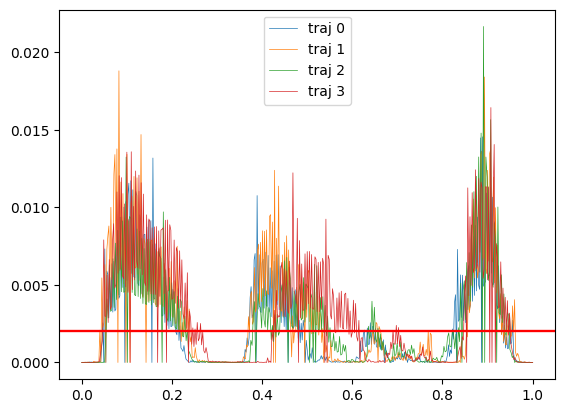

2024-08-16 16:10:14.900 | INFO     |  Creating segement of demos.
2024-08-16 16:10:14.905 | INFO     |  Creating segement of demos.
2024-08-16 16:10:14.907 | INFO     |  Creating segement of demos.
2024-08-16 16:10:14.910 | INFO     |  Creating segement of demos.
2024-08-16 16:10:14.922 | INFO     |  ... created 4 segments
2024-08-16 16:10:14.922 | INFO     |    Fitting candidate frame 1/6
2024-08-16 16:10:14.922 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/12 [00:00<?, ?it/s]

2024-08-16 16:10:15.597 | INFO     |    Fitting candidate frame 2/6
2024-08-16 16:10:15.597 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/12 [00:00<?, ?it/s]

2024-08-16 16:10:16.208 | INFO     |    Fitting candidate frame 3/6
2024-08-16 16:10:16.208 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/12 [00:00<?, ?it/s]

2024-08-16 16:10:17.210 | INFO     |    Fitting candidate frame 4/6
2024-08-16 16:10:17.211 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/12 [00:00<?, ?it/s]

2024-08-16 16:10:18.292 | INFO     |    Fitting candidate frame 5/6
2024-08-16 16:10:18.293 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/12 [00:00<?, ?it/s]

2024-08-16 16:10:19.299 | INFO     |    Fitting candidate frame 6/6
2024-08-16 16:10:19.300 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/12 [00:00<?, ?it/s]

2024-08-16 16:10:20.100 | INFO     |  Creating partial frame view of demos.
2024-08-16 16:10:20.179 | INFO     |    Fitting candidate frame 1/6
2024-08-16 16:10:20.179 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/11 [00:00<?, ?it/s]

2024-08-16 16:10:20.605 | INFO     |    Fitting candidate frame 2/6
2024-08-16 16:10:20.605 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/11 [00:00<?, ?it/s]

2024-08-16 16:10:21.109 | INFO     |    Fitting candidate frame 3/6
2024-08-16 16:10:21.109 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/11 [00:00<?, ?it/s]

2024-08-16 16:10:21.678 | INFO     |    Fitting candidate frame 4/6
2024-08-16 16:10:21.679 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/11 [00:00<?, ?it/s]

2024-08-16 16:10:22.455 | INFO     |    Fitting candidate frame 5/6
2024-08-16 16:10:22.456 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/11 [00:00<?, ?it/s]

2024-08-16 16:10:22.947 | INFO     |    Fitting candidate frame 6/6
2024-08-16 16:10:22.947 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/11 [00:00<?, ?it/s]

2024-08-16 16:10:23.540 | INFO     |  Creating partial frame view of demos.
2024-08-16 16:10:23.544 | INFO     |    Fitting candidate frame 1/6
2024-08-16 16:10:23.544 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2024-08-16 16:10:23.737 | INFO     |    Fitting candidate frame 2/6
2024-08-16 16:10:23.737 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2024-08-16 16:10:23.928 | INFO     |    Fitting candidate frame 3/6
2024-08-16 16:10:23.929 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2024-08-16 16:10:24.138 | INFO     |    Fitting candidate frame 4/6
2024-08-16 16:10:24.138 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2024-08-16 16:10:24.357 | INFO     |    Fitting candidate frame 5/6
2024-08-16 16:10:24.358 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2024-08-16 16:10:24.638 | INFO     |    Fitting candidate frame 6/6
2024-08-16 16:10:24.640 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2024-08-16 16:10:24.925 | INFO     |  Creating partial frame view of demos.
2024-08-16 16:10:24.929 | INFO     |    Fitting candidate frame 1/6
2024-08-16 16:10:24.930 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:10:25.379 | INFO     |    Fitting candidate frame 2/6
2024-08-16 16:10:25.380 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:10:26.066 | INFO     |    Fitting candidate frame 3/6
2024-08-16 16:10:26.067 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:10:26.827 | INFO     |    Fitting candidate frame 4/6
2024-08-16 16:10:26.828 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:10:27.277 | INFO     |    Fitting candidate frame 5/6
2024-08-16 16:10:27.278 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:10:27.925 | INFO     |    Fitting candidate frame 6/6
2024-08-16 16:10:27.925 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:10:28.726 | INFO     |  Creating partial frame view of demos.
2024-08-16 16:10:28.731 | INFO     |  Segmented trajs into 4 segments
2024-08-16 16:10:28.734 | INFO     |  Frame score (abs):
            ee_init      kp 0      kp 1      kp 2      kp 3      kp 4
Segment 0 -0.999564 -0.481828 -0.536014 -0.000924 -0.030582 -0.092727
Segment 1 -0.210768 -0.479621 -0.524274 -0.012969 -0.909847 -0.371255
Segment 2 -0.132841 -0.010458 -0.010737 -0.014276 -0.906183 -0.016756
Segment 3 -0.252728 -0.017208 -0.017251 -0.032177 -0.930873 -0.068365
2024-08-16 16:10:28.736 | INFO     |  Frame score (rel):
            ee_init      kp 0      kp 1      kp 2      kp 3      kp 4
Segment 0  1.000000  0.482038  0.536247  0.000925  0.030596  0.092767
Segment 1  0.231652  0.527144  0.576222  0.014254  1.000000  0.408041
Segment 2  0.146594  0.011541  0.011848  0.015754  1.000000  0.018491
Segment 3  0.271496  0.018486  0.018532  0.034566  1.000000  0.073442


Fitting segments:   0%|          | 0/4 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/12 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/11 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

((array([[2.00e+30, 2.54e+30, 3.06e+30, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [1.15e+27, 2.87e+27, 6.79e+27, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [2.15e+18, 1.73e+19, 1.27e+20, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         ...,
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 4.38e+22, 2.61e+22, 1.47e+22],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 6.31e+28, 5.42e+28, 4.32e+28]]),
  array([[4.60e+030, 5.84e+030, 7.05e+030, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [9.39e+027, 2.15e+028, 4.68e+028, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [6.11e+021, 2.77e+022, 1.20e+023, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         ...,
         [2.98e-195, 1.12e-192, 4.13e-190, ..., 4.37e+016, 1.52e+016,
          4.97e+015],
         [2.38e-223, 7.06e-221, 2.12e-218, ..., 3.49e+027, 1.80e+027,
          8.74e+026],
         [2.31e-302, 1.33e-299, 1.01e-296, ..., 3.51e+

In [11]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       global_frames=False,
                       fitting_actions=(FittingStage.INIT,)) # FittingStage.EM_HMM))


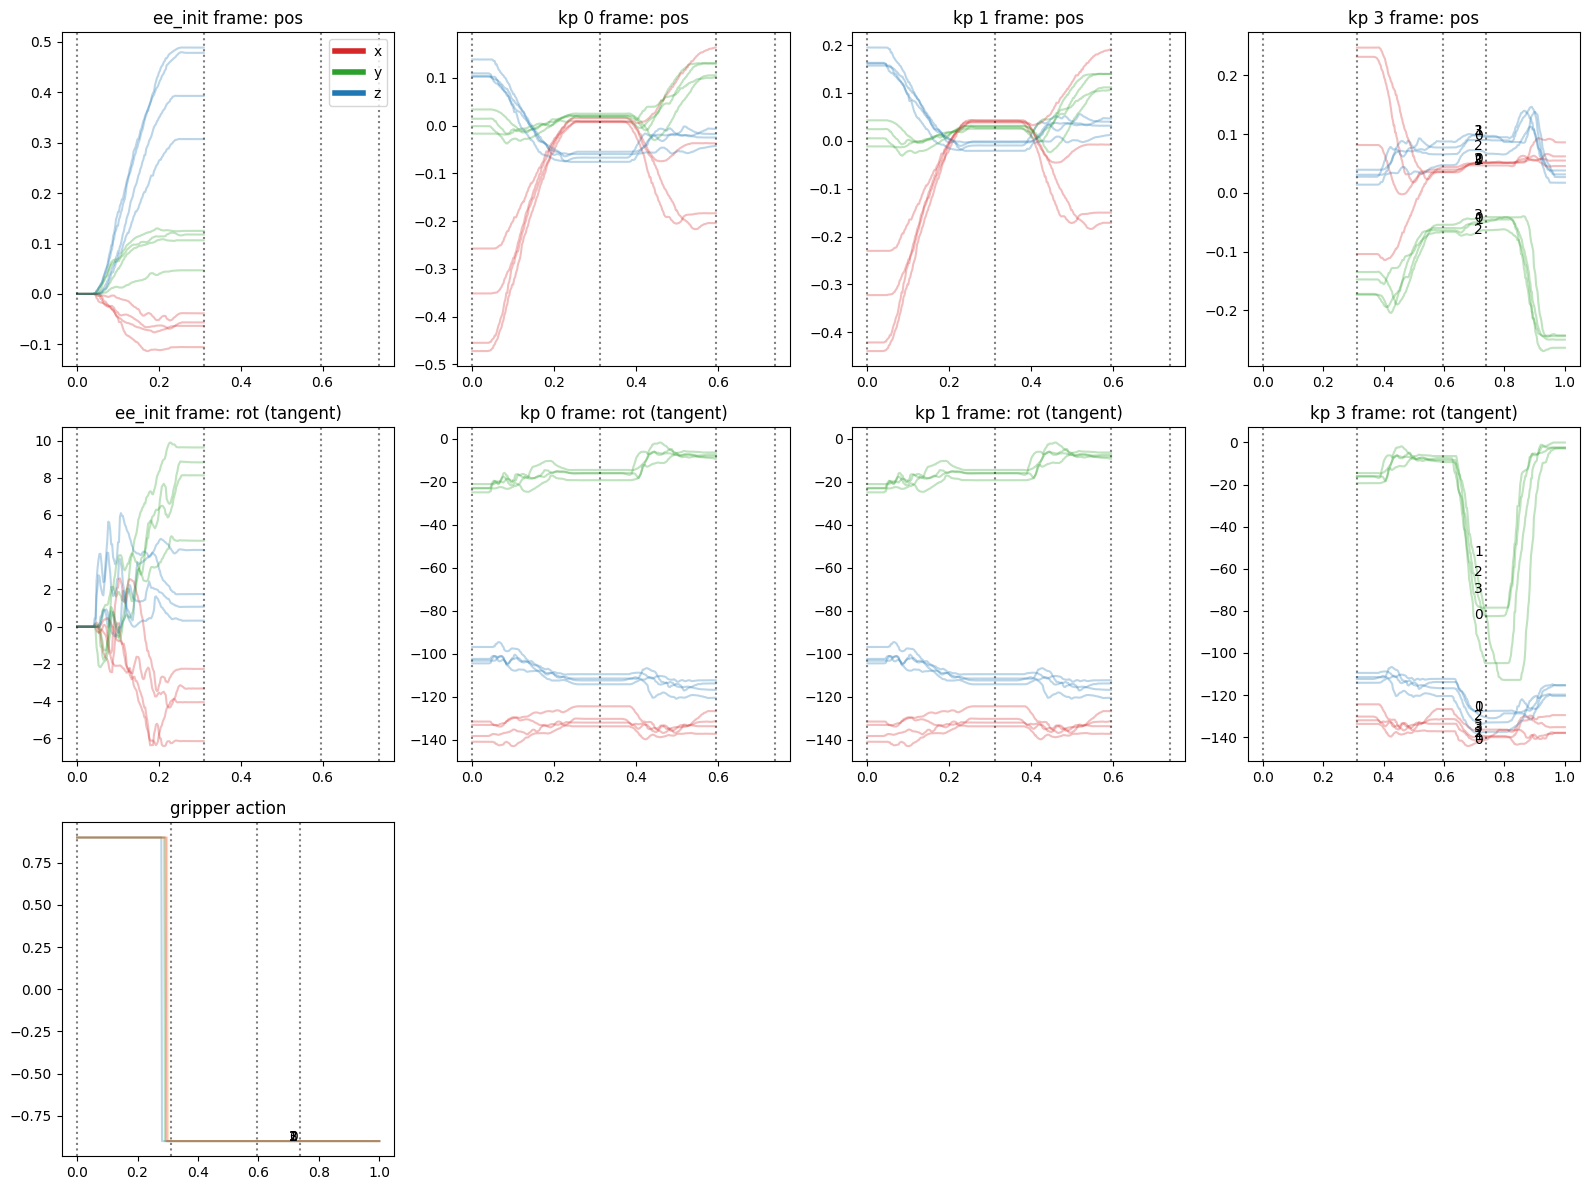

In [12]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=False,
    annotate_gaussians=True, annotate_trajs=True,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, time_based=True,)


In [13]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       global_frames=False,
                       fitting_actions=(FittingStage.EM_HMM,))


2024-08-16 16:10:35.059 | INFO     |  Fitting AutoTPGMM
2024-08-16 16:10:35.059 | INFO     |  Performing fitting actions: [EM_HMM]


Fitting segments:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-16 16:10:35.064 | INFO     |  HMM EM ...
2024-08-16 16:10:35.072 | INFO     |  HMM transition matrix not defined, initializing to uniform


HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

2024-08-16 16:10:35.444 | INFO     |  HMM init priors not defined, initializing to uniform
2024-08-16 16:10:41.218 | WARNING  |  HMM EM did not converge


HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

((array([[9.99e-01, 9.99e-01, 9.98e-01, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [5.73e-04, 1.13e-03, 2.21e-03, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [1.07e-12, 6.80e-12, 4.14e-11, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         ...,
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 6.94e-07, 4.82e-07, 3.42e-07],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 1.00e+00, 1.00e+00, 1.00e+00]]),
  array([[9.98e-001, 9.96e-001, 9.93e-001, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [2.04e-003, 3.67e-003, 6.60e-003, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [1.33e-009, 4.72e-009, 1.69e-008, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         ...,
         [6.48e-226, 1.90e-223, 5.82e-221, ..., 1.24e-014, 5.45e-015,
          2.40e-015],
         [5.18e-254, 1.20e-251, 2.99e-249, ..., 9.94e-004, 6.48e-004,
          4.21e-004],
         [0.00e+000, 0.00e+000, 0.00e+000, ..., 9.99e-

2024-08-16 16:10:47.552 | INFO     |  Did not specify time_based, deciding automatically.
2024-08-16 16:10:47.729 | WARNING  |  Skippig NaN Gaussians.


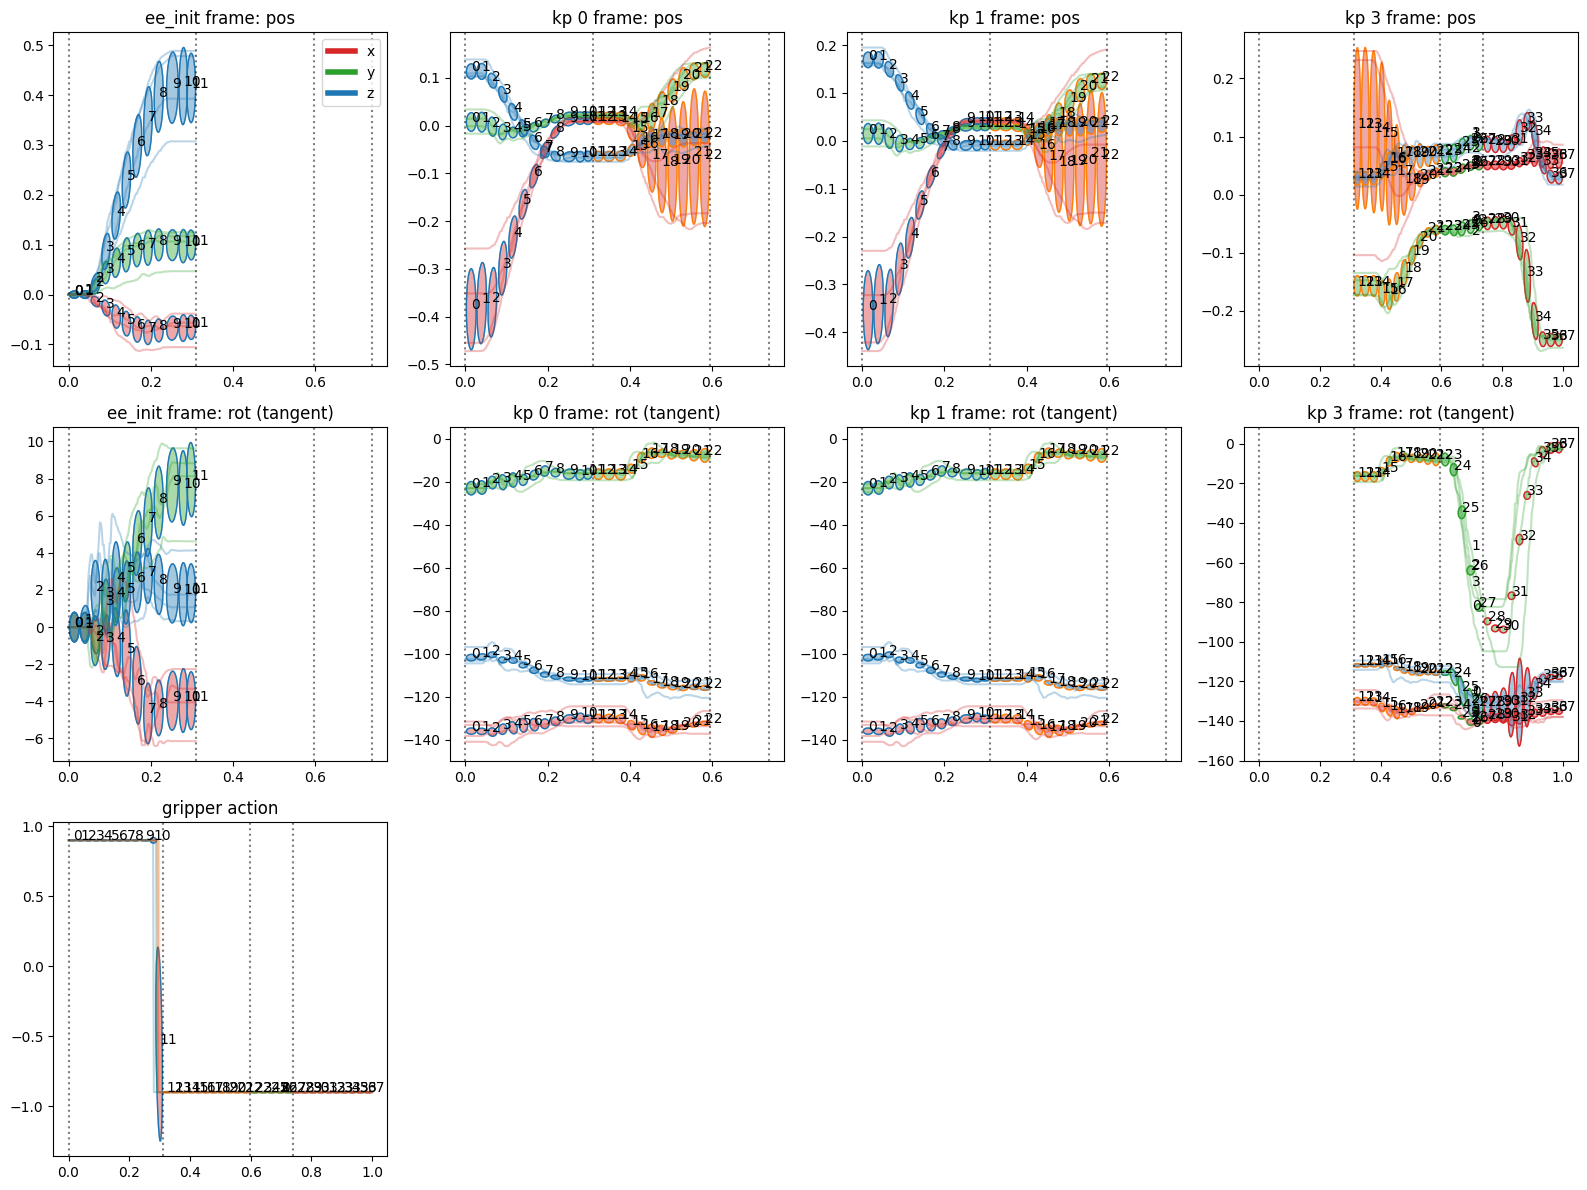

In [14]:

atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=True,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False)


In [15]:
atpgmm.to_disk(data_root / task / 'demos_gmm_policy-release.pt')

2024-08-16 16:10:54.711 | INFO     |  Saving model:


2024-08-16 16:10:54.872 | INFO     |  Did not specify time_based, deciding automatically.


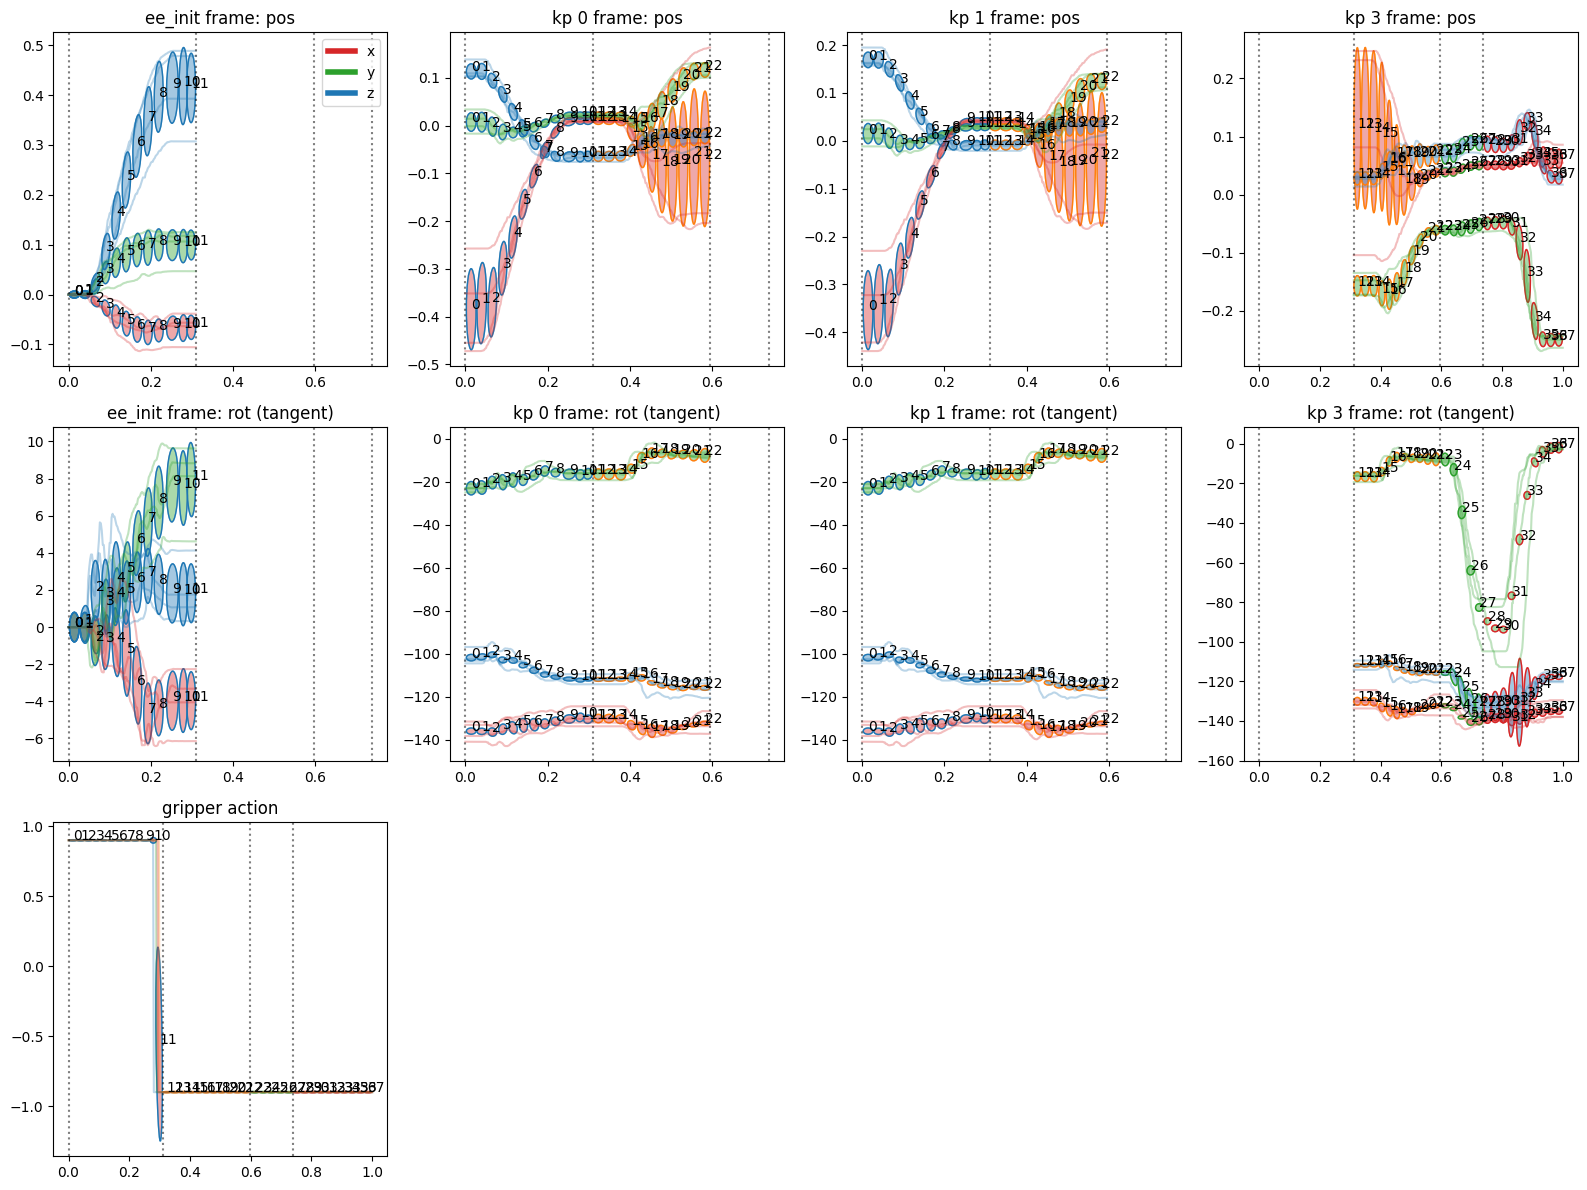

In [16]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False)


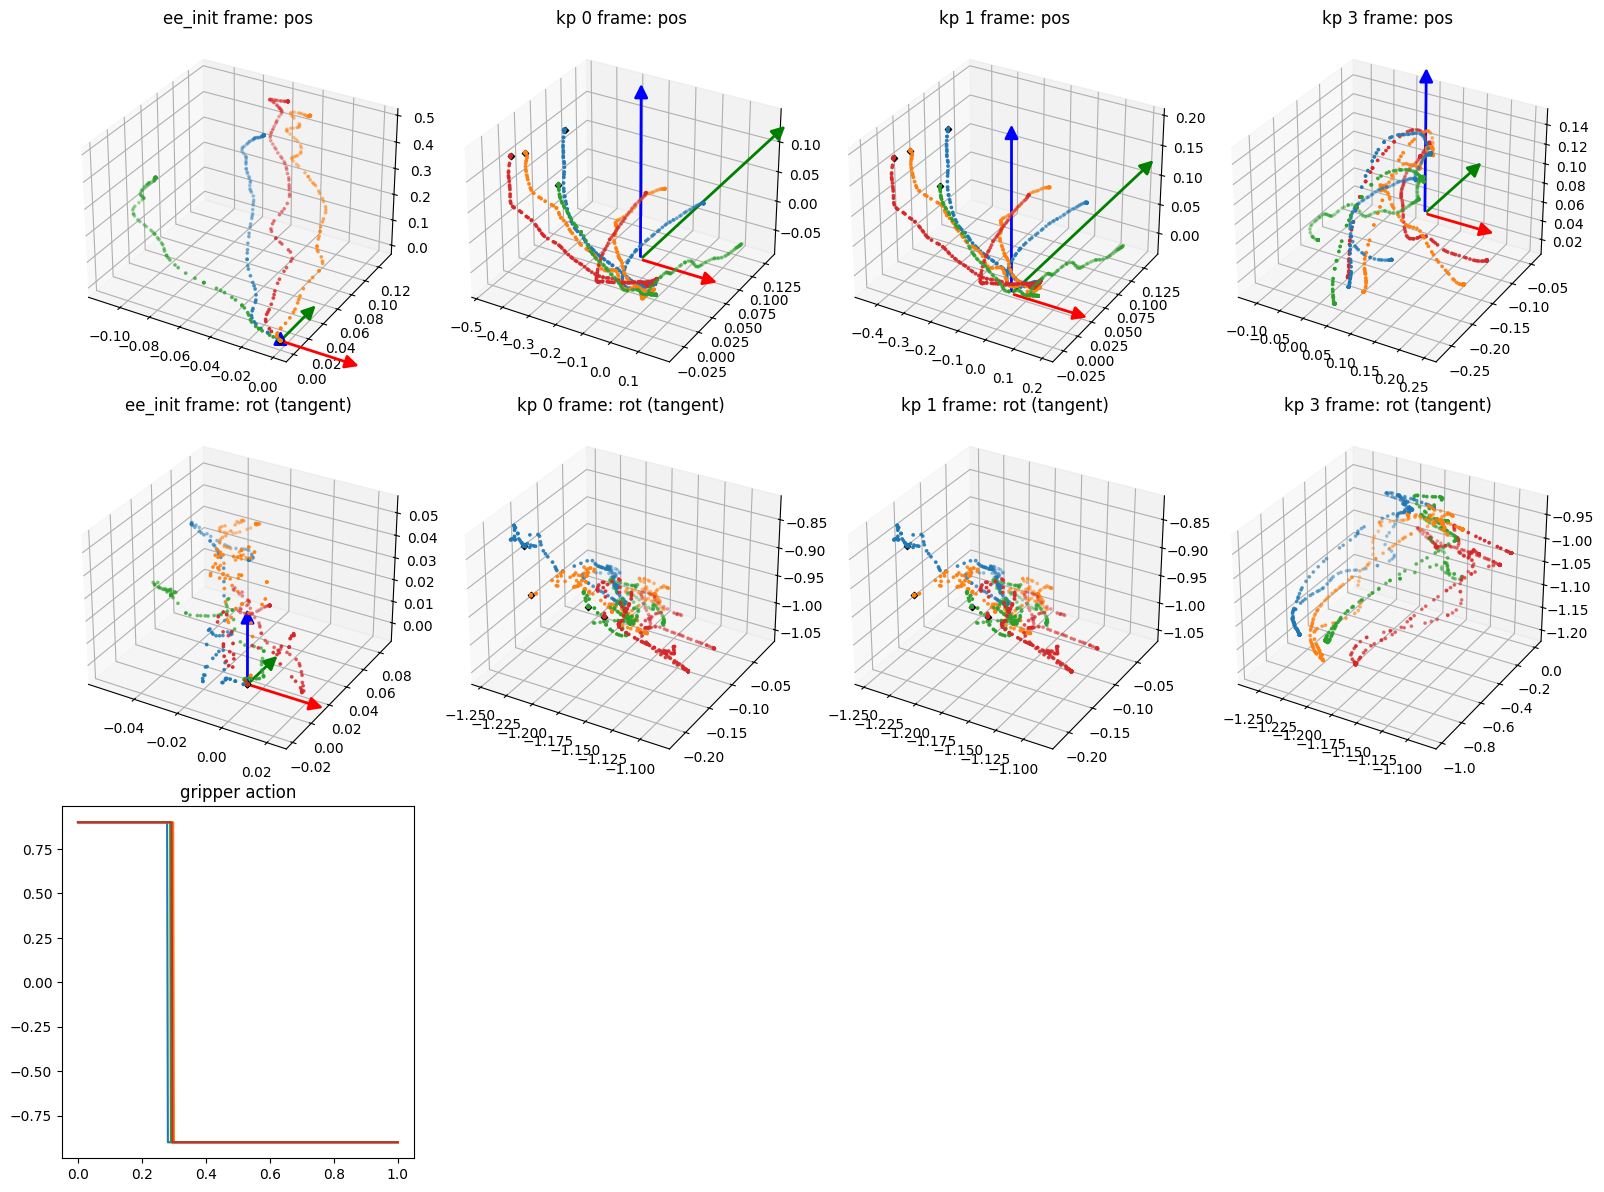

In [17]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=False,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False, time_based=False)

In [18]:
seg_local_marginals, seg_trans_marginals, seg_trans_marg_container, seg_joint_models, cascaded_hmms, (reconstructions, original_trajectories, extras) = atpgmm.reconstruct(
    strategy=tapas_gmm.policy.models.tpgmm.ReconstructionStrategy.GMR,
    use_ss=False)


2024-08-16 16:11:07.392 | INFO     |  Time-based reconstruction not specified. Auto selected True.
2024-08-16 16:11:07.537 | INFO     |  Caculated segment transition probabilities: (array([[1.]]), array([[0.98]]), array([[0.94]]))
2024-08-16 16:11:07.538 | INFO     |  Creating partial frame view of demos.
2024-08-16 16:11:08.395 | INFO     |  Assuming zero frame velocity. Should be fixed.


Transforming marginals:   0%|          | 0/4 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-16 16:11:09.205 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/4 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-16 16:11:10.357 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/4 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-16 16:11:11.032 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/4 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-16 16:11:11.761 | WARNING  |  Setting init priors of later segments to zero.


GMR:   0%|          | 0/4 [00:00<?, ?it/s]

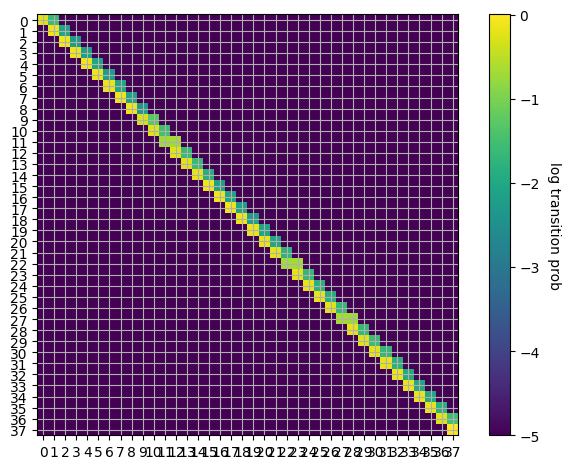

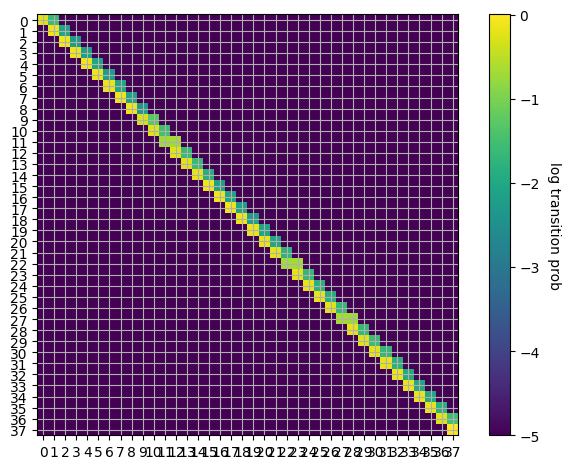

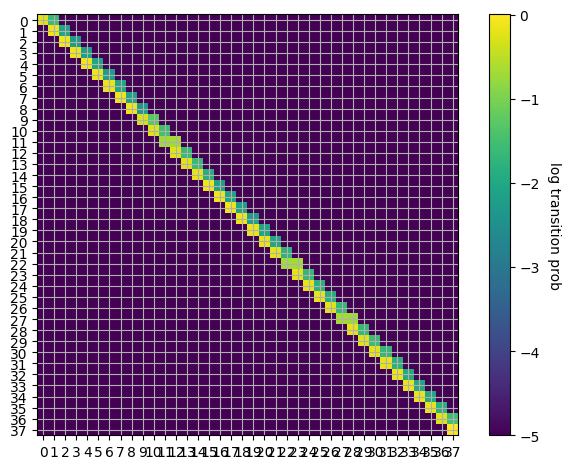

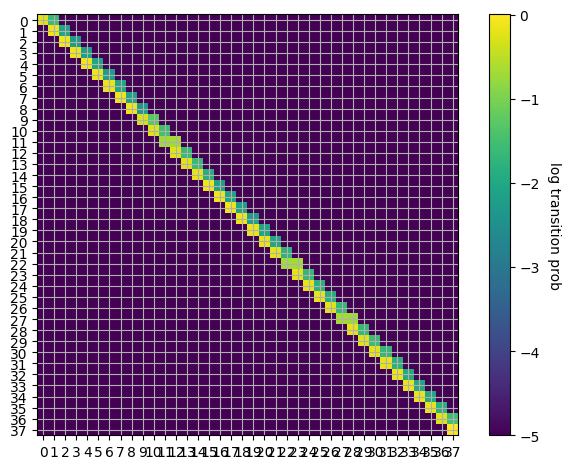

In [19]:
for cascaded_hmm in cascaded_hmms:
    plot_hmm_transition_matrix(cascaded_hmm)


2024-08-16 16:12:10.135 | INFO     |  Taking frame origins from demos.


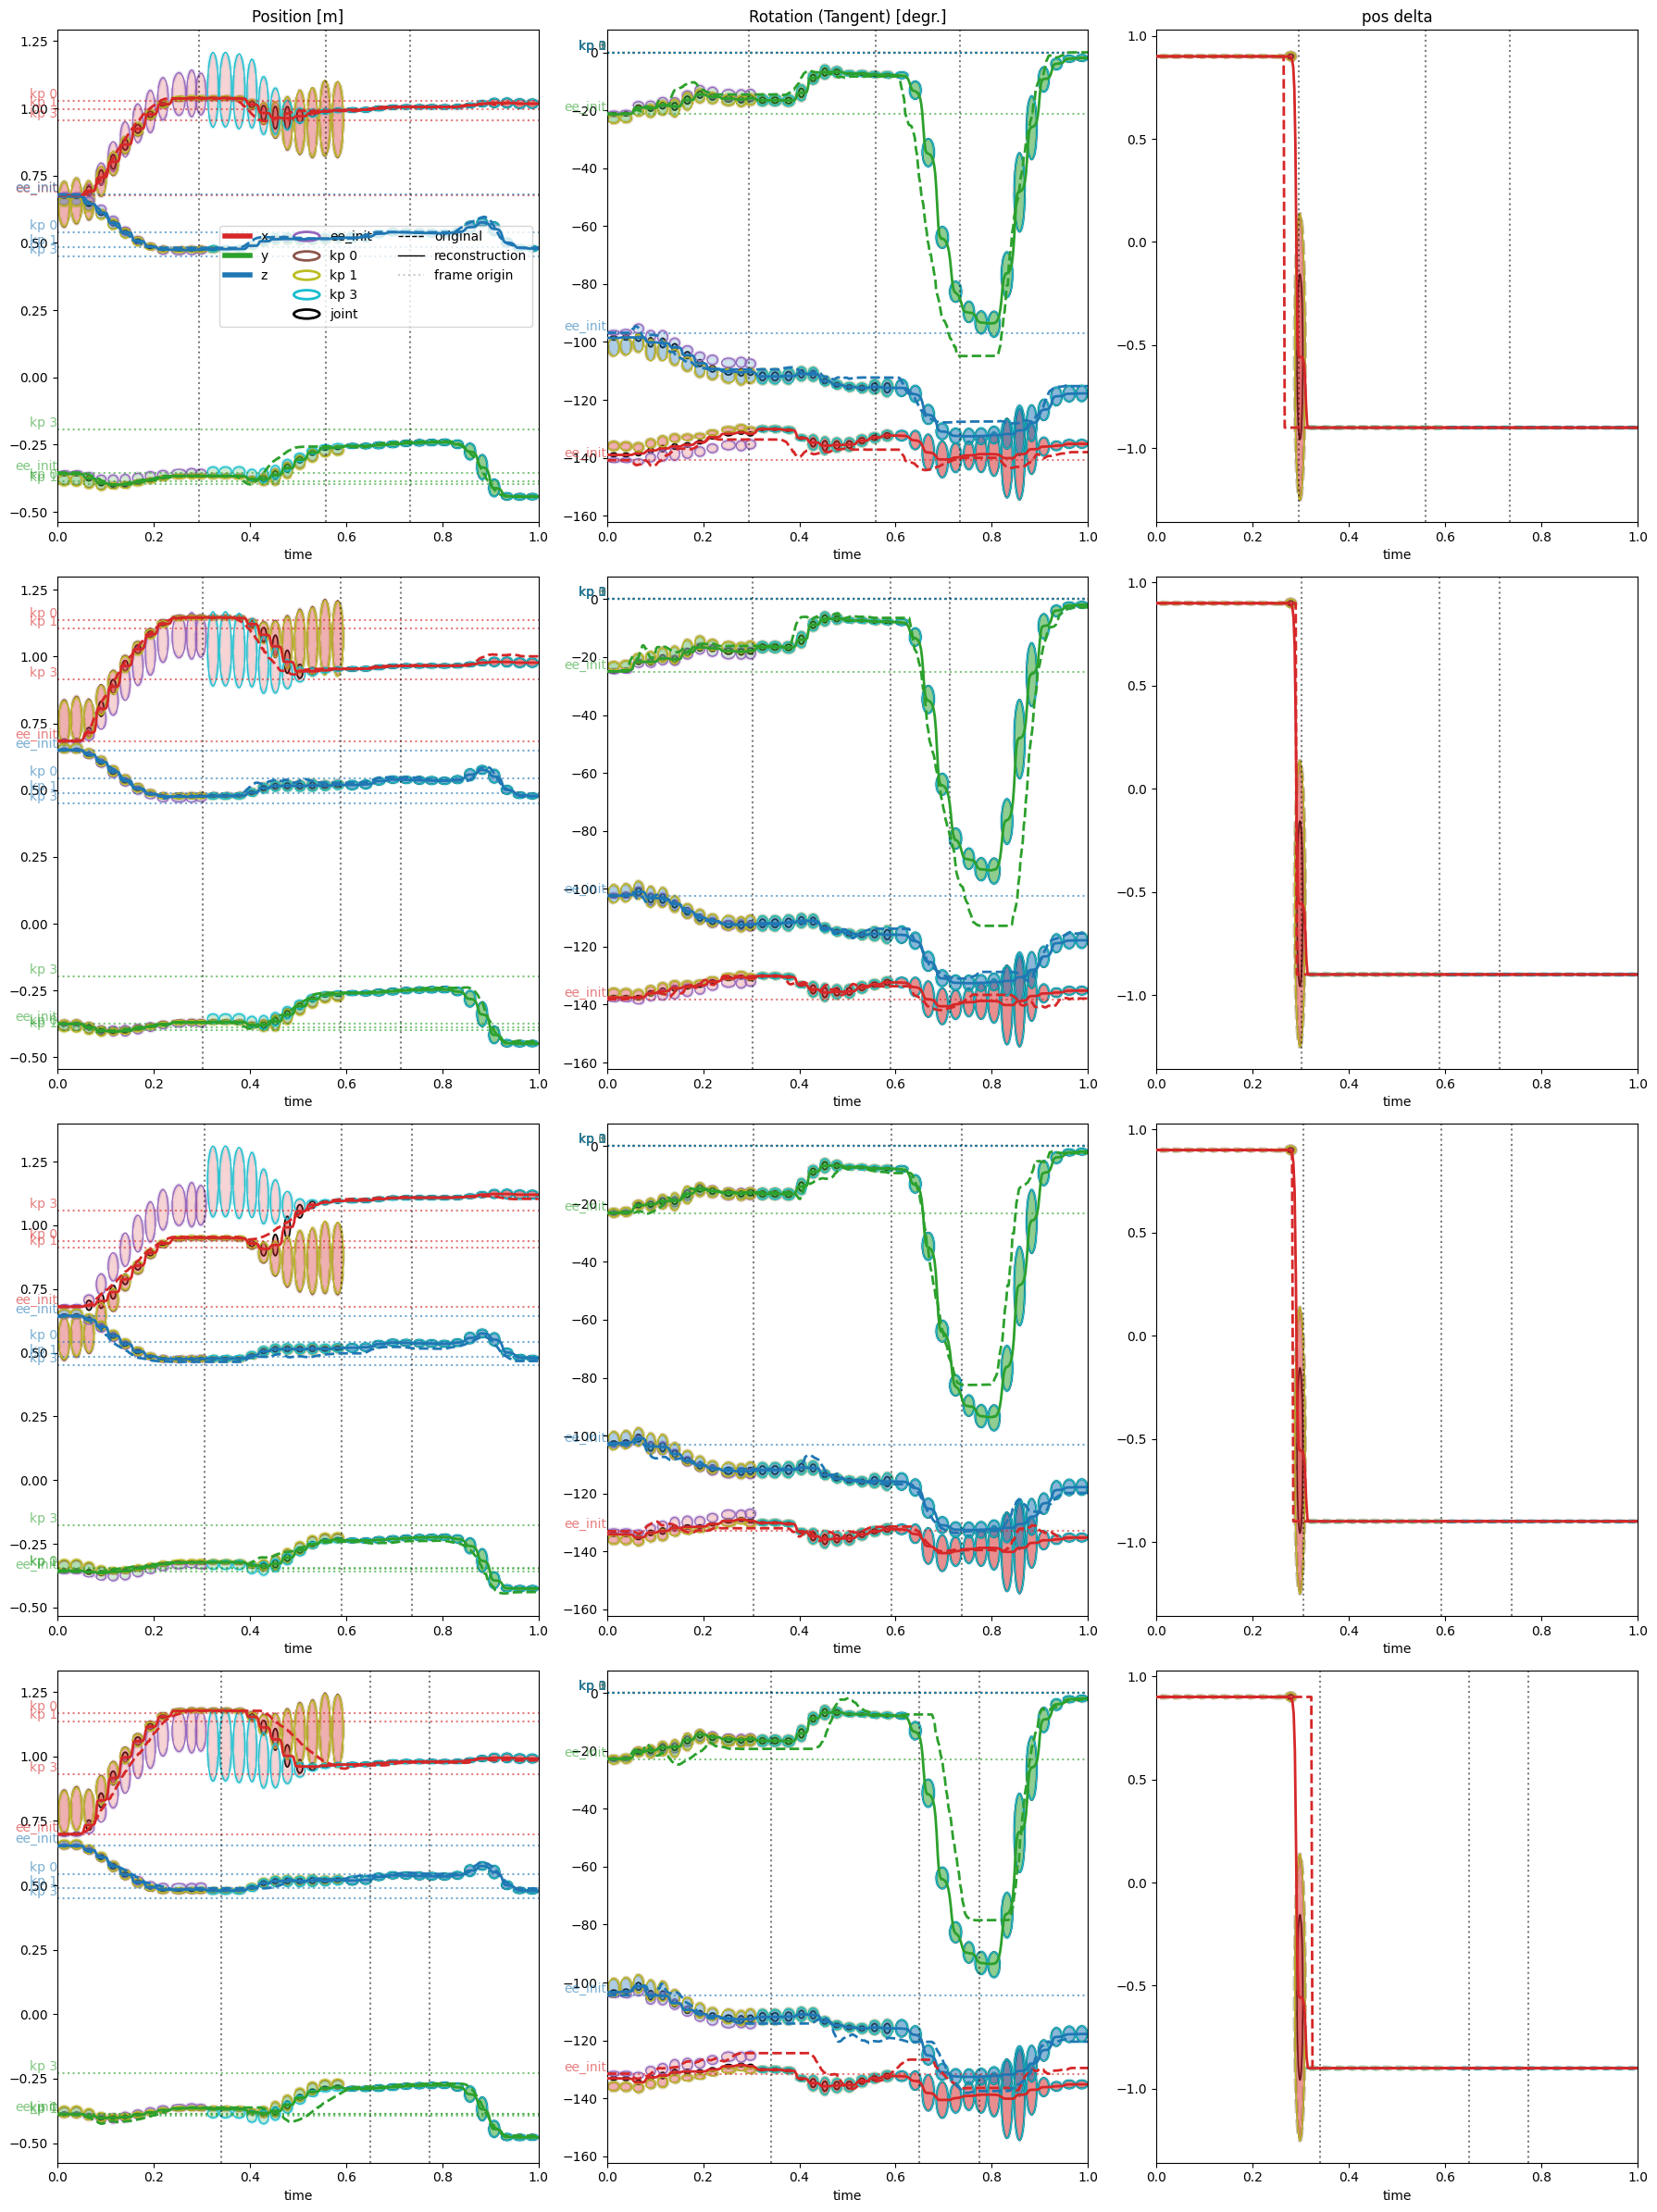

In [20]:
atpgmm.plot_reconstructions(
    seg_trans_marg_container, cascaded_hmms, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=True, equal_aspect=False, per_segment=False)


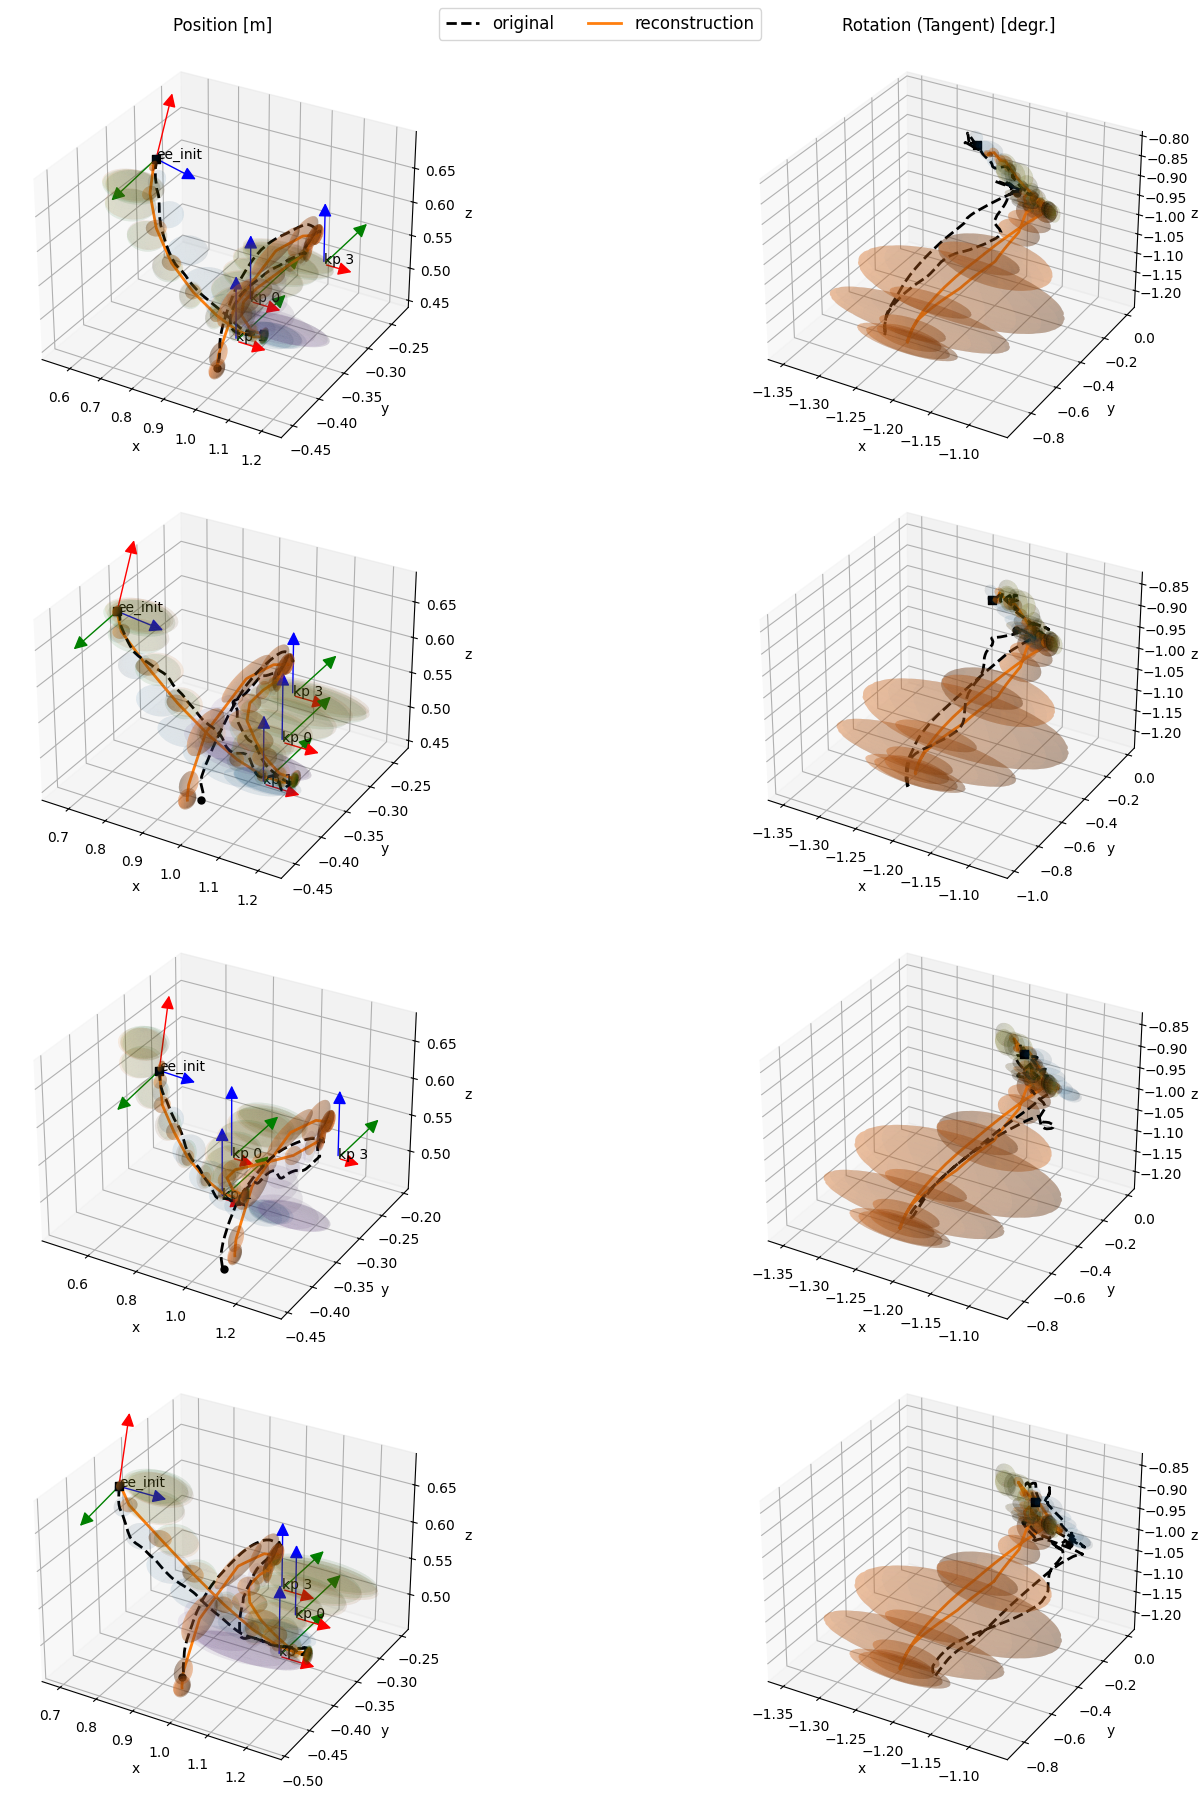

In [21]:
atpgmm.plot_reconstructions(
    seg_trans_marg_container, cascaded_hmms, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=False, equal_aspect=False, per_segment=False)